In [3]:
# !pip install seaborn
# !pip install lightgbm

In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
# from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from transformers import BertTokenizer, BertModel
import torch
is_tensor = torch.is_tensor

from sklearn.preprocessing import StandardScaler

/Users/bereket/Documents/Project and Programming Final Project/data/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/bereket/Documents/Project and Programming Final Project/data/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
df = pd.read_csv('post_user.csv')
df.drop(['location', 'comments_disabled', 'title'], axis=1, inplace=True)
df.drop(['shortcode', 'image_id', 'src', 'username', 'profile_image', 'followers', 'follows'], axis=1, inplace=True)
df.drop(['is_private'], axis=1, inplace=True) # since all the accounts are public in this dataset 
df.drop(['user_id', 'content_id'], axis=1, inplace=True)
df = df.dropna()

# df.shape

In [7]:
df = df.dropna(subset=['name'])
df = df[df['name'] != 'Handsome Dan XIX']
df['name'].unique()
df.shape

(6275, 8)

In [8]:
from scipy.stats import zscore

df['z_score'] = zscore(df['engagement_ratio'])
df_filtered = df[df['z_score'].abs() <= 3]
df = df_filtered
df.drop(['z_score'], axis=1, inplace=True)

In [9]:
df.head()

,comments_count,taken_at,likes,captions,accessibility_caption,name,is_verified,engagement_ratio
0,45.0,1.732721e+09,5936.0,Sasha is grateful for the Harvard community th...,A black lab wearing a crimson bandana sits in ...,Harvard University,True,0.002366
1,19.0,1.732639e+09,2654.0,"Humanity is doing better than ever, but it oft...",A headshot of a woman with short blonde hair. ...,Harvard University,True,0.001057
2,72.0,1.732042e+09,10253.0,Falling in love with this view of Harvard Medi...,A large white building with columns,Harvard University,True,0.004084
3,56.0,1.731867e+09,9908.0,Fall friends 🍁 \n\n#HarvardInAutumn \n\nPhoto:...,Two people sit on a stone wall of a large bric...,Harvard University,True,0.003941
4,62.0,1.731685e+09,10180.0,A perfect fall view 🍂 \n\n#HarvardInAutumn \n\...,A building with a tall white tower is framed b...,Harvard University,True,0.004051


In [10]:
df['taken_at'] =  pd.to_datetime(df['taken_at'], unit='s')
df = df.dropna(subset=['taken_at'])


df['day'] = df['taken_at'].dt.day
df['month'] = df['taken_at'].dt.month
df['year'] = df['taken_at'].dt.year

df['hour'] = df['taken_at'].dt.hour
df['minute'] = df['taken_at'].dt.minute
df['second'] = df['taken_at'].dt.second
df.drop(['taken_at'], axis=1, inplace=True)
df.shape

(6240, 13)

In [11]:
columns = df.columns.tolist()
columns.remove('engagement_ratio')

In [12]:
features, target =  df[columns].values, df['engagement_ratio'].values
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
# df['engagement_ratio'] = scaler.fit_transform(df[['engagement_ratio']]) 
df['engagement_ratio'] = np.log(df['engent_ratio'].apply(lambda e: e))

In [14]:
df = df.dropna(subset=['engagement_ratio'])
df.shape

(6240, 13)

### Finding the best time to post

In [15]:
# df['is_private'] = df['is_private'].astype(bool)
df['is_verified'] = df['is_verified'].astype(bool)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6240 entries, 0 to 6282
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   comments_count         6240 non-null   float64
 1   likes                  6240 non-null   float64
 2   captions               6240 non-null   object 
 3   accessibility_caption  6240 non-null   object 
 4   name                   6240 non-null   object 
 5   is_verified            6240 non-null   bool   
 6   engagement_ratio       6240 non-null   float64
 7   day                    6240 non-null   int32  
 8   month                  6240 non-null   int32  
 9   year                   6240 non-null   int32  
 10  hour                   6240 non-null   int32  
 11  minute                 6240 non-null   int32  
 12  second                 6240 non-null   int32  
dtypes: bool(1), float64(3), int32(6), object(3)
memory usage: 493.6+ KB


In [17]:
numerical_columns = df.select_dtypes(include=['int64', 'float64', 'bool', 'int32']).columns
categorical_columns = df.select_dtypes(include=['object']).columns

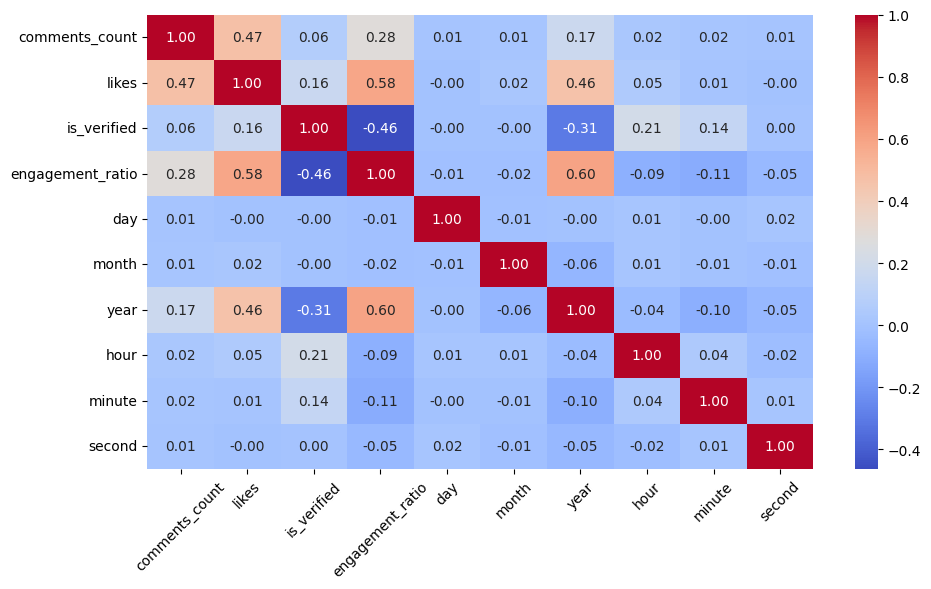

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
corr = df[numerical_columns].corr()
sns.heatmap(corr, annot=True,  fmt=".2f", cmap='coolwarm', cbar=True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
df['month'].unique()

array([11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1, 12], dtype=int32)

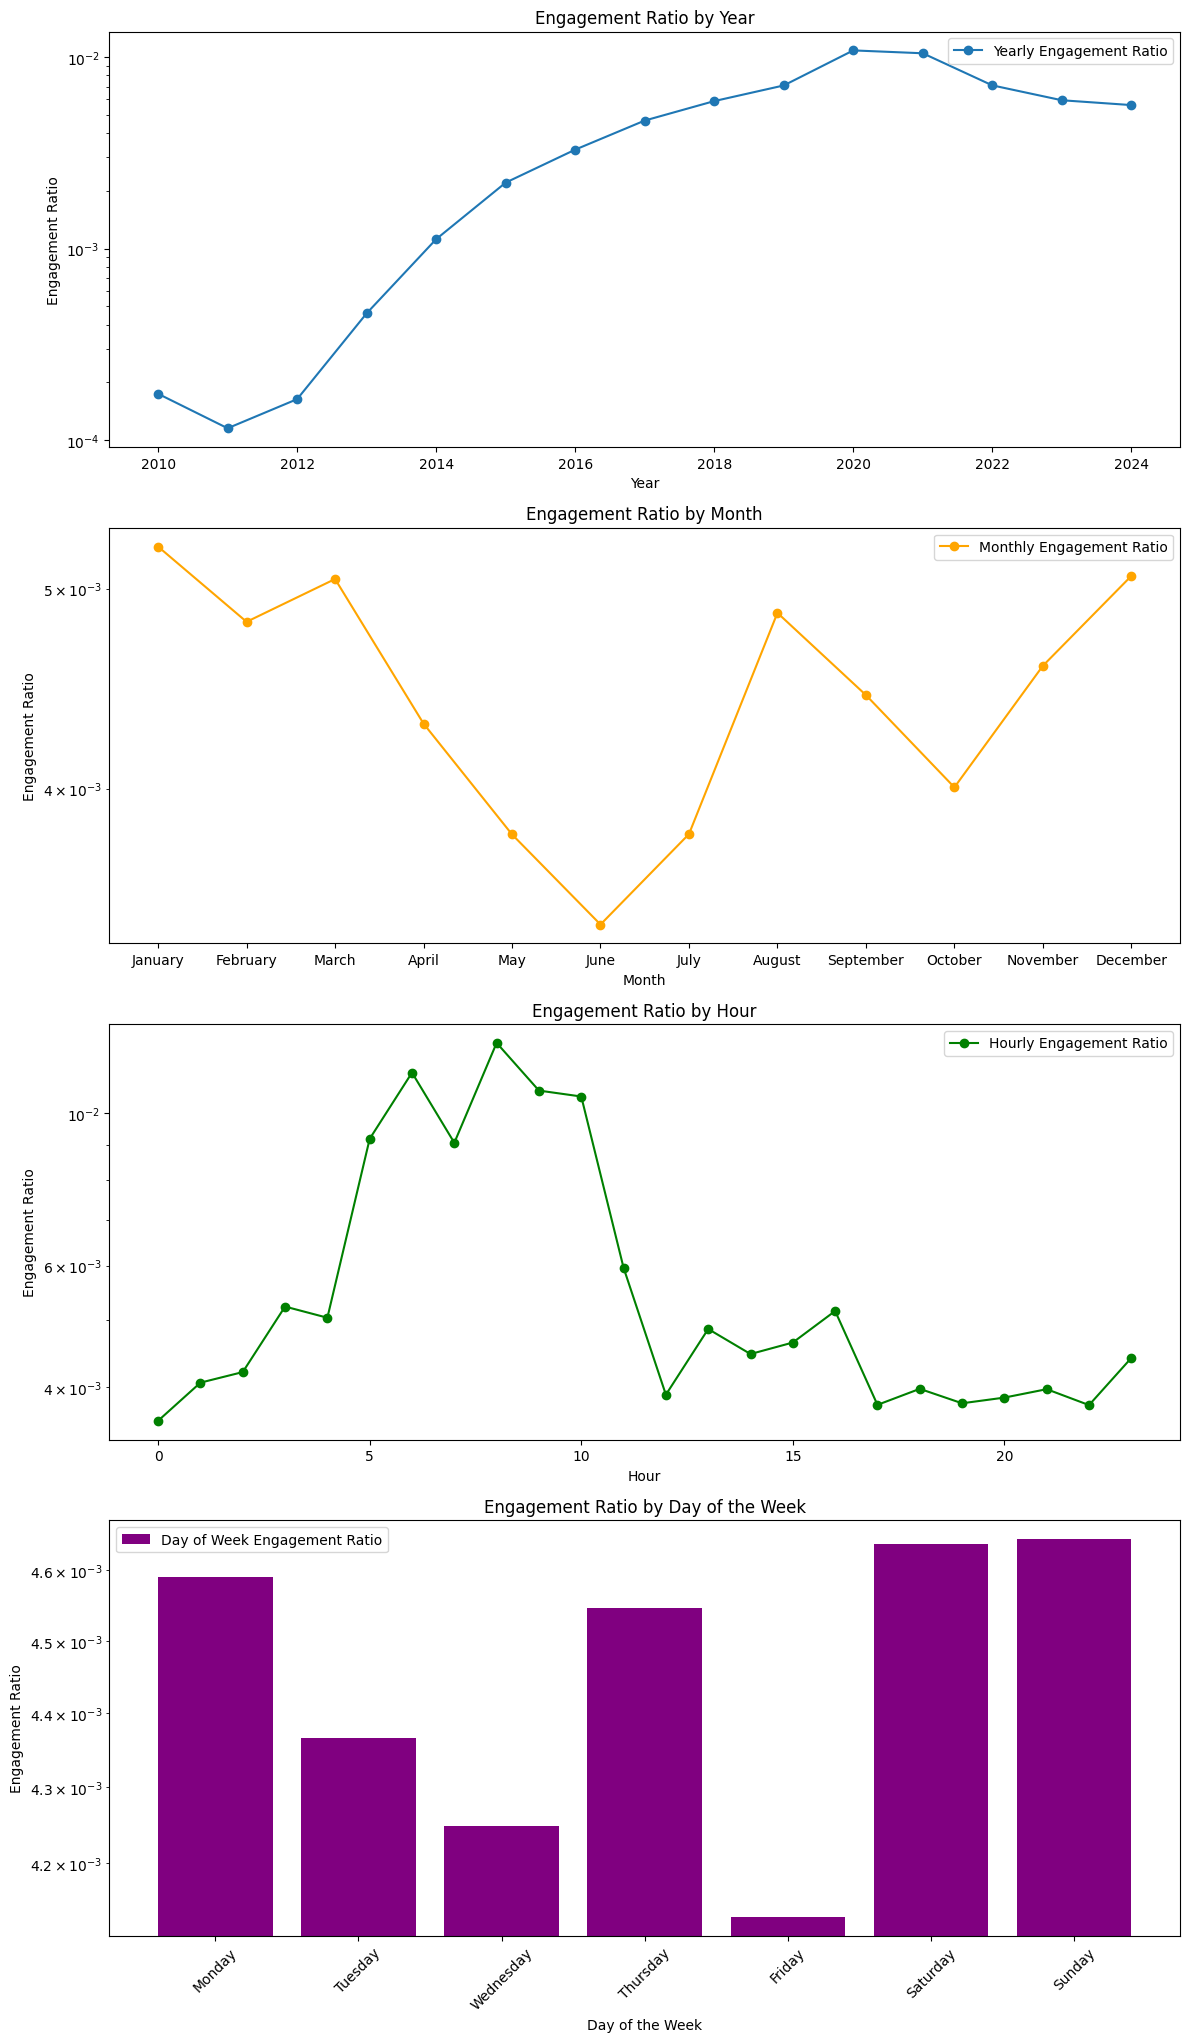

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Assuming df contains columns: 'year', 'month', 'day', 'hour', 'engagement_ratio'
# Create a 'date' column for mapping days of the week
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df['day_of_week'] = df['date'].dt.day_name()  # Get the day of the week (e.g., Monday, Tuesday)

# Days of the week in order
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Engagement ratio by day of the week
x_day = days_of_week
y_day = [df[df['day_of_week'] == day]['engagement_ratio'].mean() for day in days_of_week]

# Initialize figure and subplots
fig, axes = plt.subplots(4, 1, figsize=(12, 20), sharex=False)

# Yearly engagement ratio
x_year = years
y_year = [df[df['year'] == year]['engagement_ratio'].mean() for year in years]
axes[0].plot(x_year, y_year, marker='o', label="Yearly Engagement Ratio")
axes[0].set_title("Engagement Ratio by Year")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Engagement Ratio")
axes[0].legend()

# Monthly engagement ratio
x_month = month_val
y_month = [df[df['month'] == month]['engagement_ratio'].mean() for month in months]
axes[1].plot(x_month, y_month, marker='o', label="Monthly Engagement Ratio", color='orange')
axes[1].set_title("Engagement Ratio by Month")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Engagement Ratio")
axes[1].legend()

# Hourly engagement ratio
x_hour = hours
y_hour = [df[df['hour'] == hour]['engagement_ratio'].mean() for hour in hours]
axes[2].plot(x_hour, y_hour, marker='o', label="Hourly Engagement Ratio", color='green')
axes[2].set_title("Engagement Ratio by Hour")
axes[2].set_xlabel("Hour")
axes[2].set_ylabel("Engagement Ratio")
axes[2].legend()

# Engagement ratio by day of the week
axes[3].bar(x_day, y_day, color='purple', label="Day of Week Engagement Ratio")
axes[3].set_title("Engagement Ratio by Day of the Week")
axes[3].set_xlabel("Day of the Week")
axes[3].set_ylabel("Engagement Ratio")
axes[3].legend()

for i in range(4):
    axes[i].set_yscale('log')

# Adjust layout
plt.tight_layout()
plt.xticks(rotation=45)
plt.yscale('log')
plt.show()

### groupped by account name

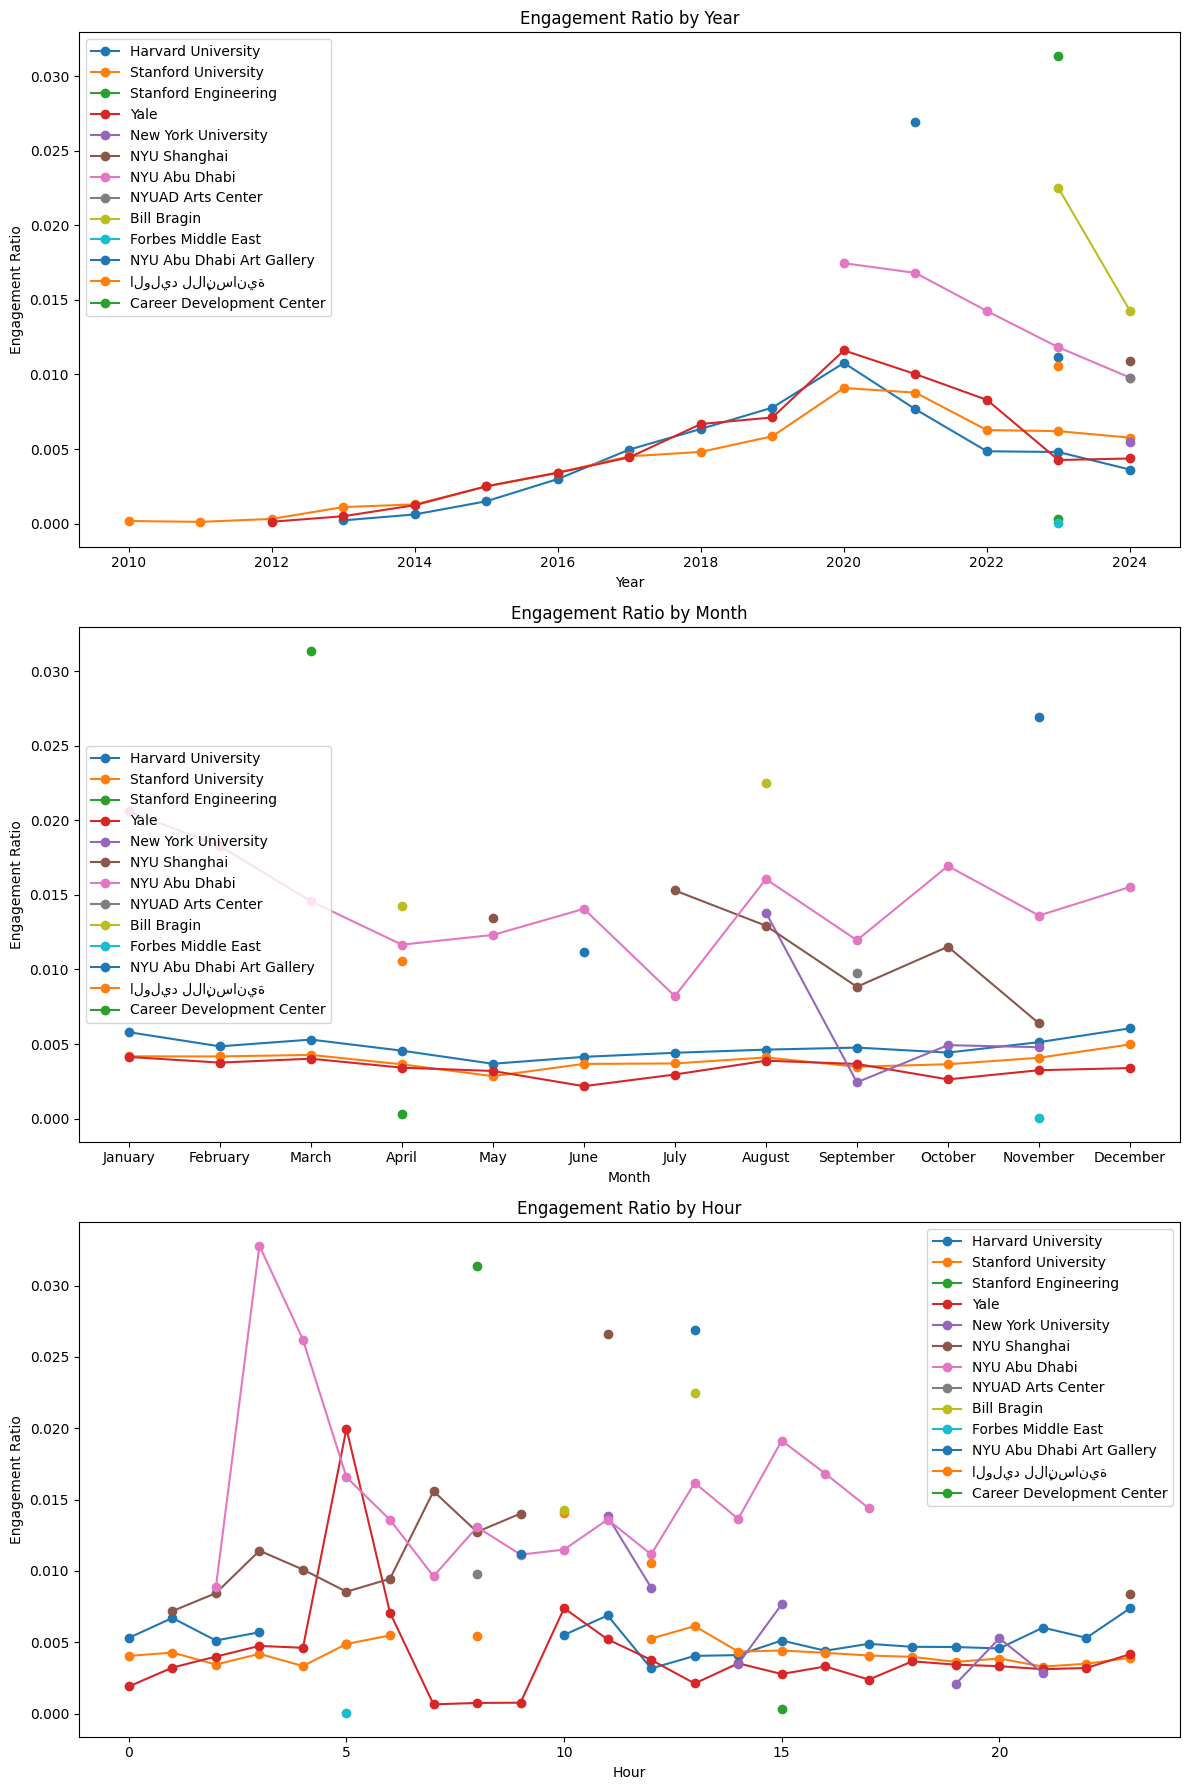

In [ ]:
names = df['name'].unique().tolist()

# Define time dimensions
years = sorted(df['year'].unique().tolist())
month_val = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
months = sorted(df['month'].unique().tolist())
hours = sorted(df['hour'].unique().tolist())

# Initialize figure and subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=False)

# Yearly engagement ratio
for name in names:
    x_year = years
    y_year = [df[(df['year'] == year) & (df['name'] == name)]['engagement_ratio'].mean() for year in years]
    axes[0].plot(x_year, y_year, marker='o', label=name)

axes[0].set_title("Engagement Ratio by Year")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Engagement Ratio")
axes[0].legend()

# Monthly engagement ratio
for name in names:
    x_month = month_val
    y_month = [df[(df['month'] == month) & (df['name'] == name)]['engagement_ratio'].mean() for month in months]
    axes[1].plot(x_month, y_month, marker='o', label=name)

axes[1].set_title("Engagement Ratio by Month")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Engagement Ratio")
axes[1].legend()

# Hourly engagement ratio
for name in names:
    x_hour = hours
    y_hour = [df[(df['hour'] == hour) & (df['name'] == name)]['engagement_ratio'].mean() for hour in hours]
    axes[2].plot(x_hour, y_hour, marker='o', label=name)

axes[2].set_title("Engagement Ratio by Hour")
axes[2].set_xlabel("Hour")
axes[2].set_ylabel("Engagement Ratio")
axes[2].legend()

# Adjust layout
plt.tight_layout()
plt.show()


### Model training

In [22]:
model = RandomForestRegressor(n_estimators=1540, random_state=42, verbose=0, n_jobs=-1)
model

RandomForestRegressor(n_estimators=1540, n_jobs=-1, random_state=42)

In [96]:
df['engagement_ratio'].describe()

count    5959.000000
mean       -6.092448
std         1.279546
min       -10.583275
25%        -6.809365
50%        -5.807572
75%        -5.204496
max        -0.848042
Name: engagement_ratio, dtype: float64

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df[['month', 'is_verified']], df['target'], test_size=0.15, random_state=42)
model.fit(X_train, y_train)

predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

KeyError: 'target'

In [98]:
df['target'] = df['engagement_ratio']#.apply(lambda x: round(x, 1))
df = df.dropna(subset=['target'])
df.shape

(5959, 14)

In [99]:
df['target'].value_counts(normalize=True)

target
-8.331983    0.001175
-8.145285    0.001175
-8.623180    0.000839
-8.497603    0.000839
-8.347898    0.000839
               ...   
-7.192761    0.000168
-6.923662    0.000168
-7.708508    0.000168
-7.648661    0.000168
-9.647181    0.000168
Name: proportion, Length: 5173, dtype: float64

In [100]:
X_train, X_test, y_train, y_test = train_test_split(df[['month', 'is_verified']], df['target'], test_size=0.15, random_state=42)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 1.4839288614116104


### caption based prediction

In [101]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from transformers import BertTokenizer, BertModel

In [33]:
captions = df['captions']

In [34]:
captions = captions.apply(lambda x: str(x) if isinstance(x, str) else "")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

tokens = tokenizer(captions.tolist(), padding=True, truncation=True, return_tensors="pt")

In [35]:
# Perform inference
with torch.no_grad():
    outputs = model(
        input_ids=tokens['input_ids'],
        attention_mask=tokens['attention_mask']
    )
    embeddings = outputs.last_hidden_state

KeyboardInterrupt: 